In [1]:
import csv
import os
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data.sampler import SubsetRandomSampler
import tkinter as tk
from tkinter import filedialog


c:\Users\u7oh2m\Anaconda3\envs\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = tk.Tk()
root.withdraw()

TEST_DATA_DIR = filedialog.askdirectory(
    title="Select folder containing images for testing"
)
print(TEST_DATA_DIR)
MODEL_PATH = "../model/"
BATCH_SIZE = 128


C:/Users/u7oh2m/WorkingStudent/Personal/GitHub/aiornot/test


# Inference

In [3]:
model = torch.load(MODEL_PATH + "model_resenet18_best_epoch_14.pt")

In [4]:
class ImageTestData(Dataset):
    def __init__(self, folder):
        test_images = sorted(
            glob(folder + "/" + "*.jpg"),
            key=lambda x: int(os.path.splitext(os.path.basename(x))[0]),
        )
        self.fpaths = test_images
        # self.fpaths = test_images[:500]

        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        im = cv2.imread(f)[:, :, ::-1]
        im = cv2.resize(im, (224, 224))
        im = torch.tensor(im / 255)
        im = im.permute(2, 0, 1)
        im = self.normalize(im)
        return im.float().to(device)

In [5]:
test = ImageTestData(TEST_DATA_DIR)
test_dl = DataLoader(
    test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False
)

In [6]:
@torch.no_grad()
def run_inference(test_dl):
    output = []

    for __, batch in enumerate(iter(test_dl)):
        x = batch
        model.eval()
        prediction = model(x)
        # print(prediction.shape)
        output.extend(prediction.cpu().tolist())
    return output


In [ ]:
from torch_snippets import *
# Prepare output labels
output_labels = run_inference(test_dl)

In [ ]:
output_labels = torch.FloatTensor(output_labels)
output_labels = torch.argmax(output_labels, dim=1)
test_image_paths = sorted(
    glob(TEST_DATA_DIR + "/" + "*.jpg"),
    key=lambda x: int(os.path.splitext(os.path.basename(x))[0]),
)
test_images = [os.path.basename(x) for x in test_image_paths]
# print(test_images[:5])
# print(output[:5])
print(len(output_labels))
print(len(test_images))

tensor i64 0

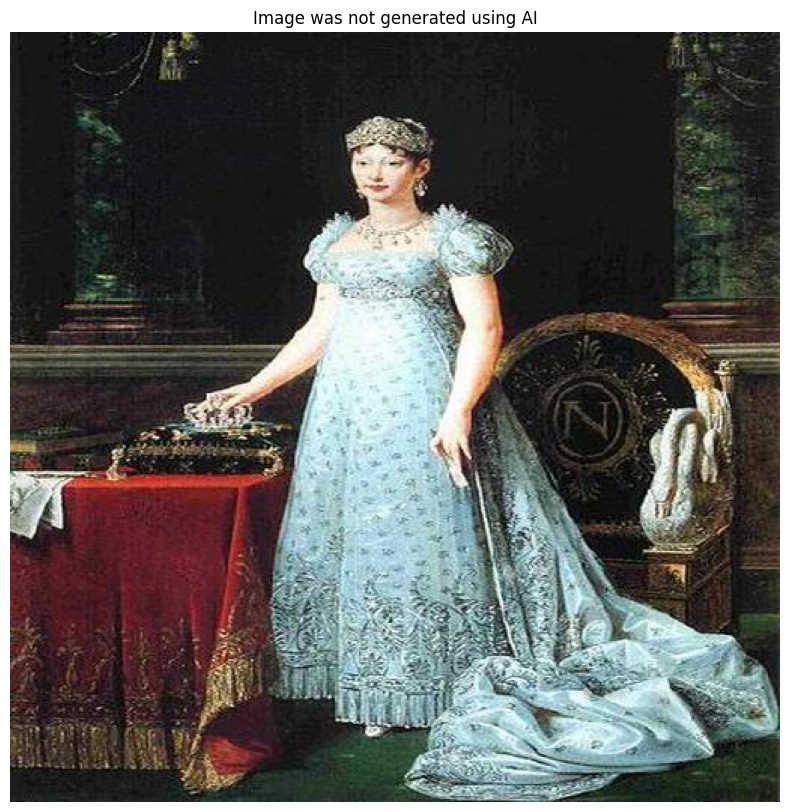

tensor i64 0

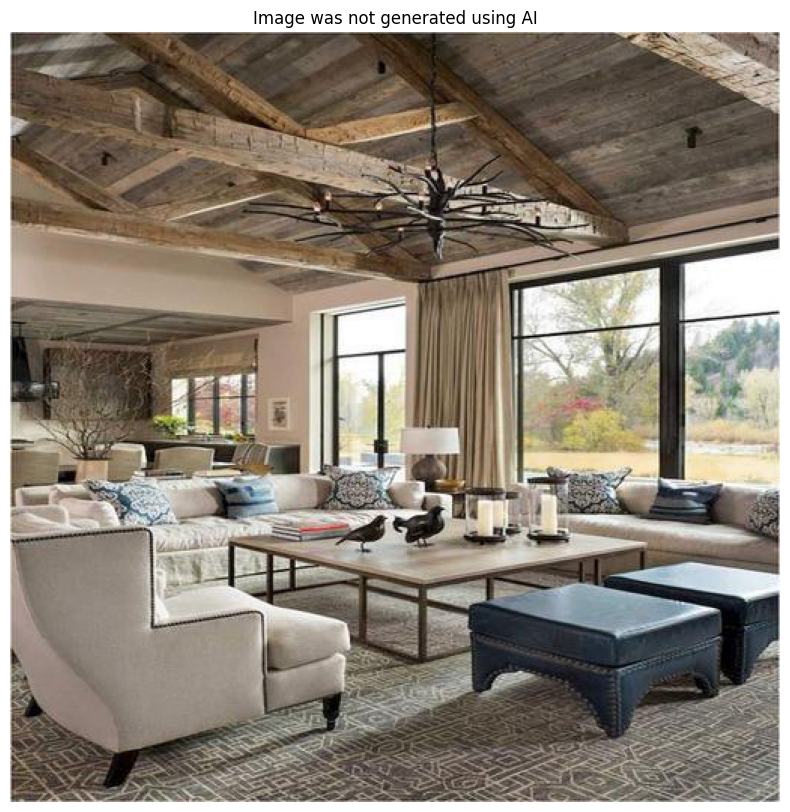

tensor i64 1

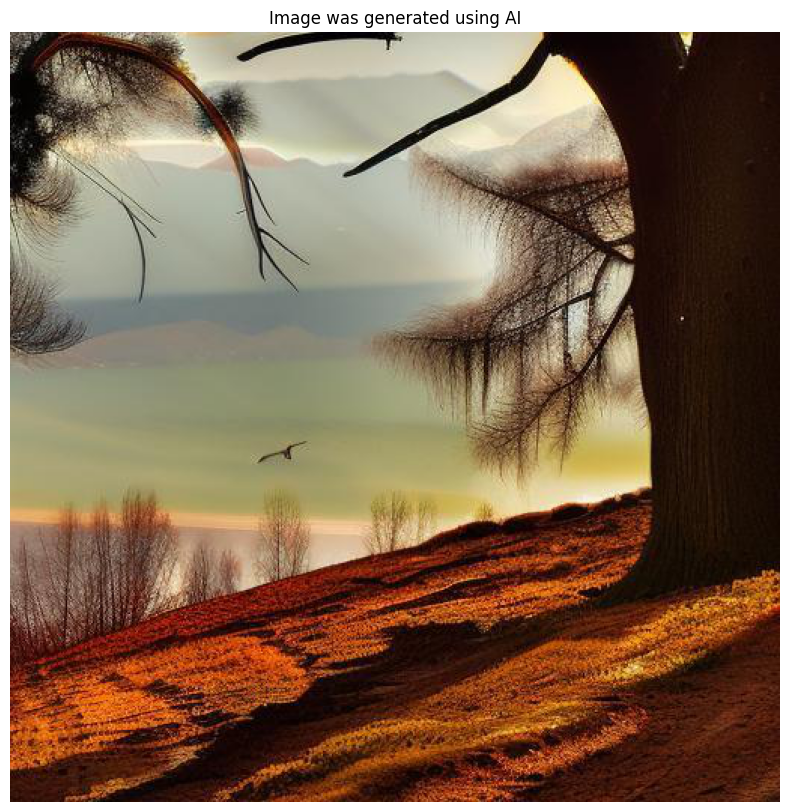

tensor i64 1

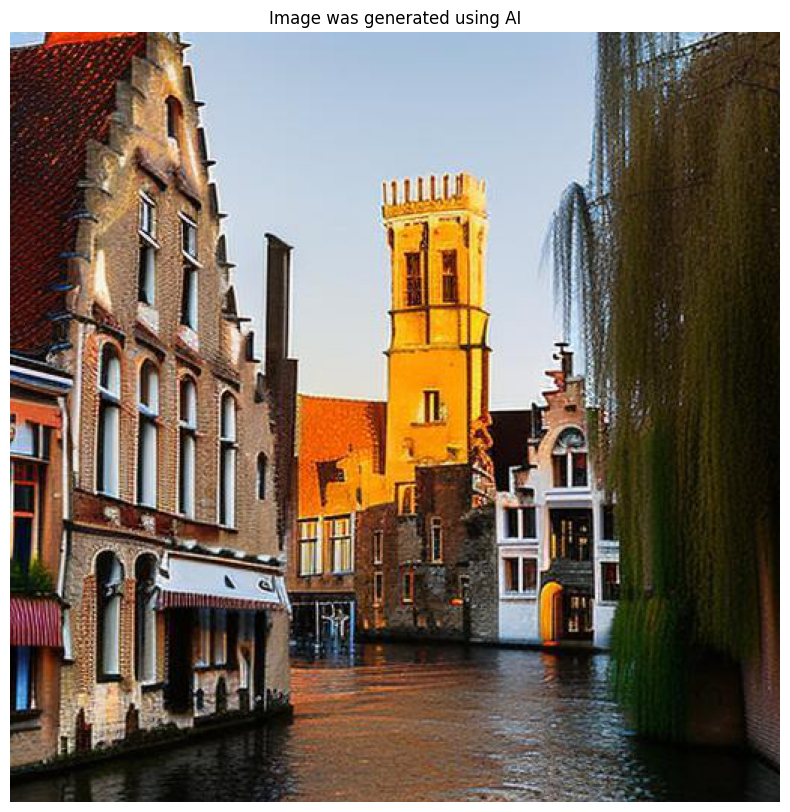

tensor i64 0

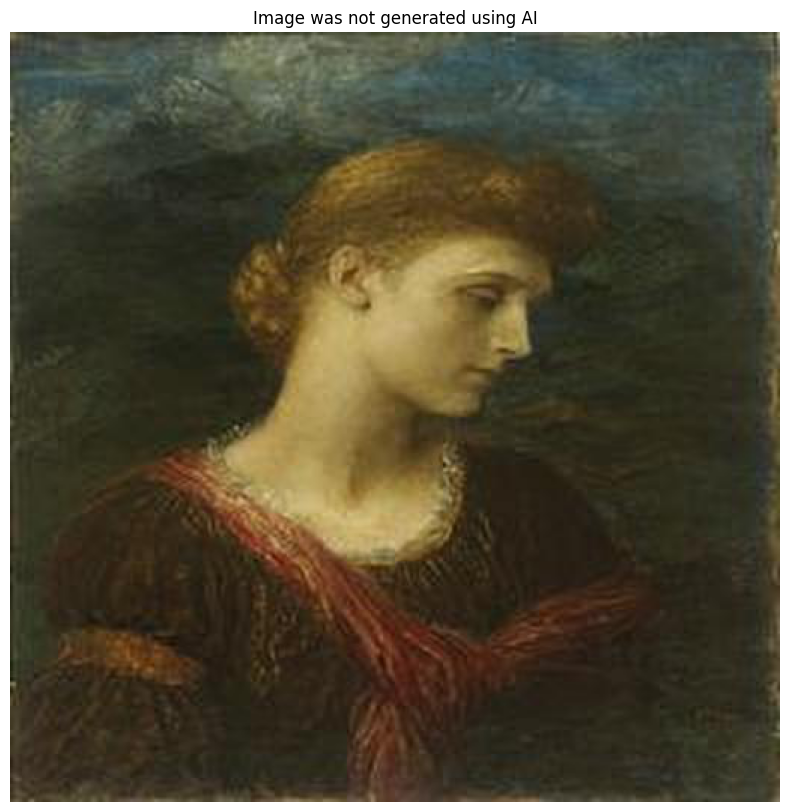

In [22]:
for test_image, output_label in zip(test_image_paths[:5],output_labels[:5]):
    print(output_label)
    text = (
        "Image was not generated using AI"
        if int(output_label) < 0.5
        else "Image was generated using AI"
    )
    show(
        torchvision.utils.make_grid(torchvision.io.read_image(test_image)),
        title=text,
    )
    plt.show()

In [ ]:
# Prepare csv
csv_file_path = "../submission.csv"
with open(csv_file_path, "w", newline="") as f:
    w = csv.writer(f)

    # Check for empty csv
    if os.stat(csv_file_path).st_size == 0:
        # First header row
        csv_row = ["id", "label"]
        w.writerow(csv_row)

    for i in range(len(output)):
        csv_row = [str(test_images[i]), float(output[i])]
        w.writerow(csv_row)